# Credit Risk Analysis

### Introduction
This tutorial shows how quantum algorithms can be used for credit risk analysis.
More precisely, how Quantum Amplitude Estimation (QAE) can be used to estimate risk measures with a quadratic speed-up over classical Monte Carlo simulation.
The tutorial is based on the following papers:

- [Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.](https://www.nature.com/articles/s41534-019-0130-6) [Woerner2019]
- [Credit Risk Analysis using Quantum Computers. Egger et al. (2019)](https://arxiv.org/abs/1907.03044) [Egger2019]

A general introduction to QAE can be found in the following paper:

- [Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.](http://arxiv.org/abs/quant-ph/0005055)

The structure of the tutorial is as follows:

1. [Problem Definition](#Problem-Definition)
2. [Uncertainty Model](#Uncertainty-Model)
3. [Expected Loss](#Expected-Loss)
4. [Cumulative Distribution Function](#Cumulative-Distribution-Function)
5. [Value at Risk](#Value-at-Risk)
6. [Conditional Value at Risk](#Conditional-Value-at-Risk)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem

### Problem Definition

In this tutorial we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
[Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca](https://arxiv.org/abs/1412.1183)



The problem is defined by the following parameters:
- number of qubits used to represent $Z$, denoted by $n_z$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1)$
- loss given default for asset $k$, denoted by $\lambda_k$
- confidence level for VaR / CVaR $\alpha \in [0, 1]$.

In [48]:
# set problem parameters
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2 ** n_z)
p_zeros = [0.15, 0.25, 0.2]
rhos = [0.1, 0.05, 0.15]
lgd = [1, 2, 2]
K = len(p_zeros)
alpha = 0.05

### Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K 
\left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),
$$

where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

In [49]:
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

u = GCI(n_z, z_max, p_zeros, rhos)

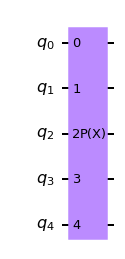

In [50]:
u.draw()

We now use the simulator to validate the circuit that constructs $|\Psi\rangle$ and compute the corresponding exact values for
- expected loss $\mathbb{E}[L]$
- PDF and CDF of $L$ 
- value at risk $VaR(L)$ and corresponding probability
- conditional value at risk $CVaR(L)$

In [51]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend("qasm_simulator"))

In [52]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2 ** n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
#state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):

    # get binary representation
    b = ("{0:0%sb}" % num_qubits).format(i)
    prob = np.abs(a) ** 2

    # extract value of Z and corresponding probability
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if b[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]

values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

In [53]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                1.0270
Value at Risk VaR[L]:              4.0000
P[L <= VaR[L]]:                    0.9889
Conditional Value at Risk CVaR[L]: 5.0000


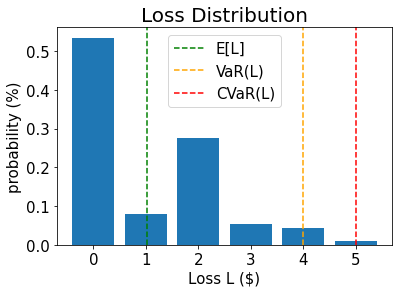

In [54]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

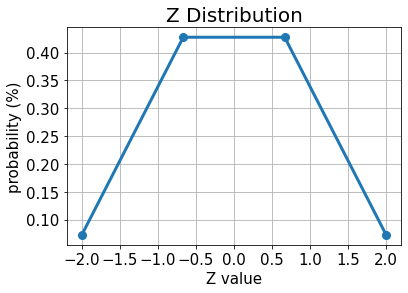

In [55]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

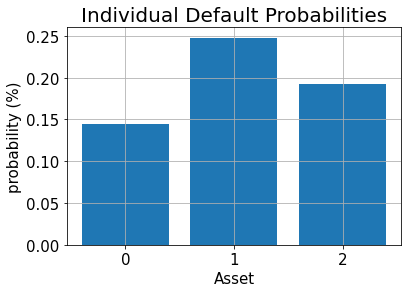

In [56]:
# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

### Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto 
| L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right), $$

which allows to run amplitude estimation to evaluate the expected loss.

2
3
[1, 2, 2]


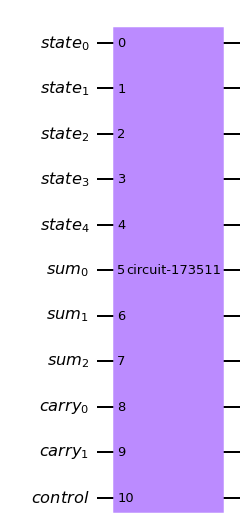

In [70]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder

agg = WeightedAdder(n_z + K, [0] * n_z + lgd)
print(n_z)
print(K)
print(lgd)
agg.draw()

In [71]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

Create the state preparation circuit:

In [72]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits,         "state")
qr_sum   = QuantumRegister(agg.num_sum_qubits,   "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj   = QuantumRegister(1, "objective")



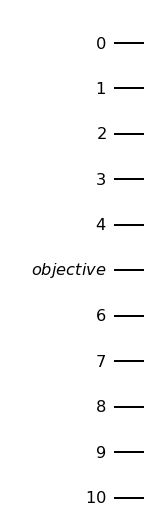

In [69]:
#define the circuit
state_preparation = QuantumCircuit(qr_state[:], qr_obj, qr_sum[:], qr_carry[:], name="A")
state_preparation.draw()

In [63]:
# load the random variable
state_preparation.append(u.to_gate(), qr_state)

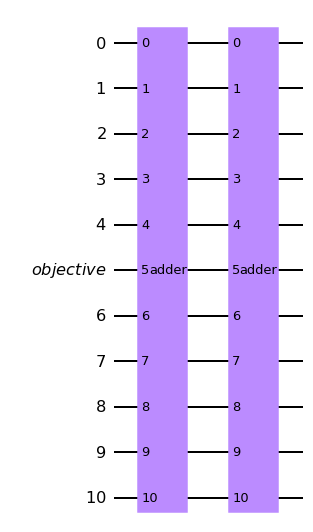

In [76]:
# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])
state_preparation.draw()

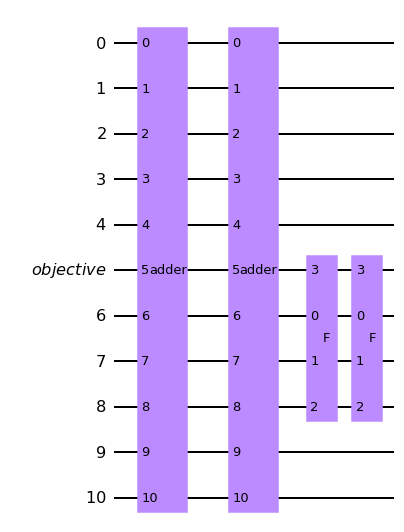

In [78]:
# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
state_preparation.draw()

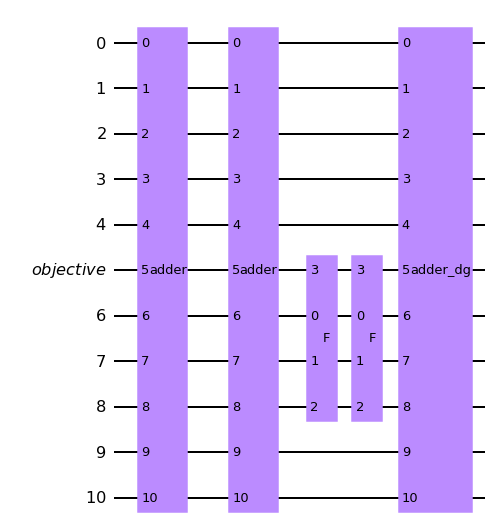

In [80]:
# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])
state_preparation.draw()

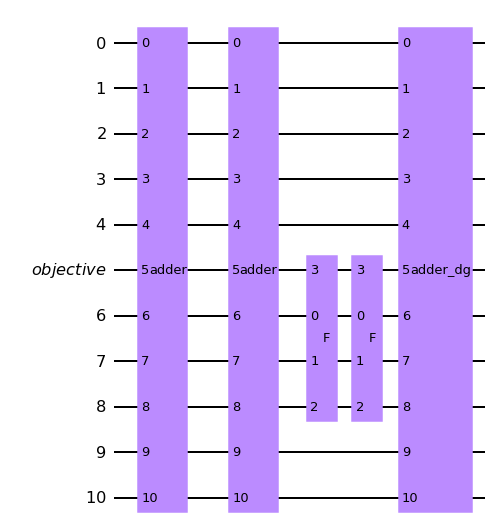

In [81]:
# draw the circuit
state_preparation.draw()

Before we use QAE to estimate the expected loss, we validate the quantum circuit representing the objective function by just simulating it directly and analyzing the probability of the objective qubit being in the $|1\rangle$ state, i.e., the value QAE will eventually approximate.

In [82]:
job = execute(state_preparation, backend=Aer.get_backend("qasm_simulator"))
print(job)

In [84]:
# evaluate resulting statevector
value = 0
state = job.result().get_statevector()
print(state)

Statevector([-1.+1.2246468e-16j, -0.+0.0000000e+00j],
            dims=(2,))


In [85]:
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   1.0270
Exact Operator Value:  0.0000
Mapped Operator value: -3.8662


Next we run QAE to estimate the expected loss with a quadratic speed-up over classical Monte Carlo simulation.

In [86]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	1.0270
Estimated value:	7.0196
Confidence interval: 	[6.9538, 7.0853]


### Cumulative Distribution Function

Instead of the expected loss (which could also be estimated efficiently using classical techniques) we now estimate the cumulative distribution function (CDF) of the loss.
Classically, this either involves evaluating all the possible combinations of defaulting assets, or many classical samples in a Monte Carlo simulation. Algorithms based on QAE have the potential to significantly speed up this analysis in the future.

To estimate the CDF, i.e., the probability $\mathbb{P}[L \leq x]$, we again apply $\mathcal{S}$ to compute the total loss, and then apply a comparator that for a given value $x$ acts as

$$ \mathcal{C}: |L\rangle_n|0> \mapsto 
\begin{cases} 
|L\rangle_n|1> & \text{if}\quad L \leq x \\
|L\rangle_n|0> & \text{if}\quad L > x.
\end{cases} $$

The resulting quantum state can be written as

$$ \sum_{L = 0}^{x} \sqrt{p_{L}}|L\rangle_{n_s}|1\rangle + 
\sum_{L = x+1}^{2^{n_s}-1} \sqrt{p_{L}}|L\rangle_{n_s}|0\rangle, $$

where we directly assume the summed up loss values and corresponding probabilities instead of presenting the details of the uncertainty model.

The CDF($x$) equals the probability of measuring $|1\rangle$ in the objective qubit and QAE can be directly used to estimate it.

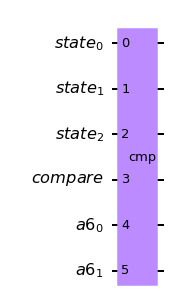

In [87]:
# set x value to estimate the CDF
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

In [92]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state  = QuantumRegister(u.num_qubits, "state")
    qr_sum    = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry  = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj    = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")
        # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")
    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])

    return state_preparation


    

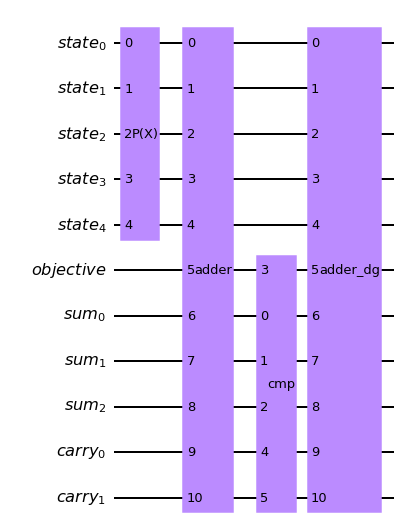

In [94]:
 
state_preparation = get_cdf_circuit(x_eval)
state_preparation.draw()

Again, we first use quantum simulation to validate the quantum circuit.

In [96]:
job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))
print(job)

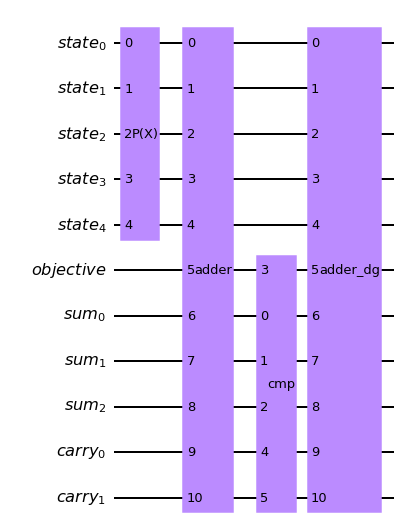

In [97]:
state_preparation.draw()

In [99]:
# evaluate resulting statevector
var_prob = 0
state = job.result().get_statevector()
print(state)

Statevector([-1.77185555e-32+1.52784602e-33j,
             -9.86076132e-32-3.44375879e-32j,
             -1.35585468e-31+5.84700048e-32j, ...,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [100]:
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        var_prob += prob
print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(2) = 1.0000
Exact    CDF(2) = 0.8905


Next we run QAE to estimate the CDF for a given $x$.

In [101]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation

In [102]:
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.8905
Estimated value:	1.0000
Confidence interval: 	[0.9999, 1.0000]


### Value at Risk

In the following we use a bisection search and QAE to efficiently evaluate the CDF to estimate the value at risk.

In [103]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator="aer_simulator"):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    
    qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [104]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [105]:
# run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         2       1.000     5            1.000
-1           0.000         0       0.618     2            1.000
 0           0.618         1       0.944     2            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [106]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  2
Exact Value at Risk:      4
Estimated Probability:    1.000
Exact Probability:        0.989


### Conditional Value at Risk

Last, we compute the CVaR, i.e. the expected value of the loss conditional to it being larger than or equal to the VaR.
To do so, we evaluate a piecewise linear objective function $f(L)$, dependent on the total loss $L$, that is given by

$$
f(L) = \begin{cases} 
0 & \text{if}\quad L \leq VaR \\
L & \text{if}\quad L > VaR.
\end{cases}
$$

To normalize, we have to divide the resulting expected value by the VaR-probability, i.e. $\mathbb{P}[L \leq VaR]$.

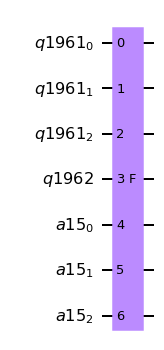

In [108]:
# define linear objective
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

cvar_objective.draw()

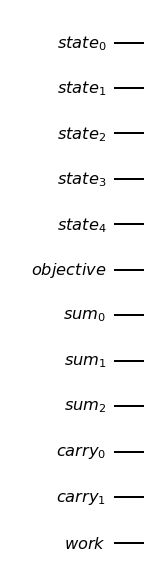

In [110]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum   = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj   = QuantumRegister(1, "objective")
qr_work  = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")
state_preparation.draw()

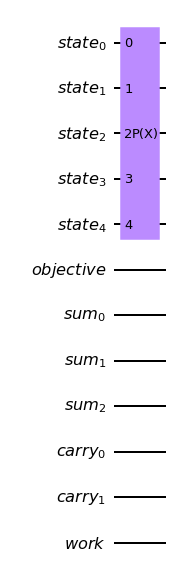

In [111]:
# load the random variable
state_preparation.append(u, qr_state)
state_preparation.draw()

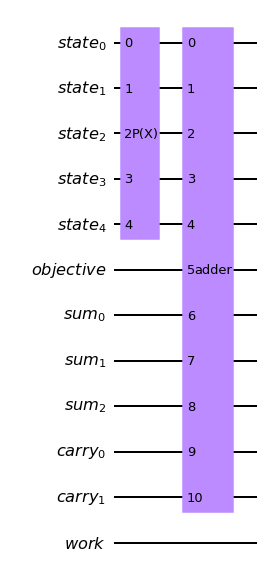

In [113]:
# aggregate
state_preparation.append(agg, qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])
state_preparation.draw()

In [118]:
# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

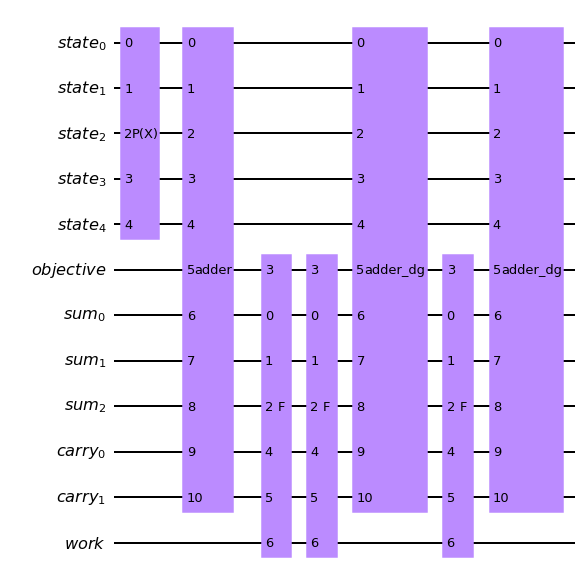

In [119]:
# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_obj[:] + qr_sum[:] + qr_carry[:])
state_preparation.draw()

Again, we first use quantum simulation to validate the quantum circuit.

In [120]:
job = execute(state_preparation, backend=Aer.get_backend("qasm_simulator"))

In [121]:
# evaluate resulting statevector
value = 0
#state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 61508.1790
Exact CVaR:     5.0000


Next we run QAE to estimate the CVaR.

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cvar = ae_cvar.estimate(problem)

In [ ]:
# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

In [34]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright